In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

Matplotlib is building the font cache; this may take a moment.


In [17]:

def getData(fileName, possiible_labels, total_attributes, limit_instances=0):

  # Abre o arquivo
  file = open('datasets/' + fileName)
  csvreader = csv.reader(file, delimiter =' ')

  data = []

  # Coloca o csv lido em um array
  # O csv tem uma última coluna vazia, por isso a descartamos no processo
  for row in csvreader:
    data.append(row[:-1])

  X = []
  Y = []

  # Pega os dados crus e os divide em atributos e rótulos.
  iteration_limit = len(data) if limit_instances == 0 else limit_instances
  for i in range(iteration_limit):

    # Inicializa o array de atributos para cada elemento (73 é o número de atributos)
    lx = []
    for j in range(total_attributes):
      lx.append(np.nan)

    # Trata os valores para se encaixar no modelo de dados aceito pelo sklearn
    for j in range(1, len(data[i])):
      attribute = int(data[i][j].split(":")[0]) - 1
      lx[attribute] = float(data[i][j].split(":")[1])

    X.append(lx)

    # Os rótulos obtidos pelo csv estão todos juntos no primeiro atributo, separados por virgula
    # Para cada um dos rótulos possíveis (definido em possible_labels), verifica se o elemento contém ou não cada um dos rótulus
    # e cria novas colunas na tabela com valores 0 ou 1 que indicam se o elemento tem ou não determinado rótulo
    ly = []
    for j in range(len(possible_labels)):
      ly.append(1 if possible_labels[j] in data[i][0].split(",") else 0)
    Y.append(ly)

  # Para valores ausentes, coloca-se a média dos outros elementos para aquele atributo
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  X = imp.fit_transform(X)

  return [X, Y]

class RunResult:
  algorithm: str
  dataset: str
  accuracy_score: float
  hamming_loss: float
  precision: float
  recall: float

  def __init__(self, algorithm, dataset, accuracy_score, hamming_loss, precision, recall):
    self.algorithm = algorithm
    self.dataset = dataset
    self.accuracy_score = accuracy_score
    self.hamming_loss = hamming_loss
    self.precision = precision
    self.recall = recall

results = []

## Dataset Yeast


---
O dataset yeast é um conjunto de dados de leveduras(fermentos) que consiste em uma interação proteína-proteína. Os métodos de detecção de interação levaram à descoberta de milhares de interações entre proteínas, e ajudam fomentar a relevância em conjuntos de dados de grandes escala para a biologia atual.

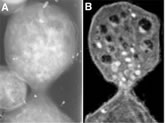


In [10]:
# Dataset Yeast
possible_labels = []
total_attributes = 103

for i in range(15):
  possible_labels.append(str(i))

X_train, Y_train = getData("yeast/yeast_train", possible_labels, total_attributes)
X_test, Y_test = getData("yeast/yeast_test", possible_labels, total_attributes)

# Scene

In [ ]:
possible_labels = ['0', '1', '2', '3', '4', '5']

X_test, Y_test = getData('scene/scene_test', possible_labels, 294)
X_train, Y_train = getData('scene/scene_train', possible_labels, 294)

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

br = BinaryRelevance(RandomForestClassifier())

br.fit(np.array(X_train), np.array(Y_train))

pred = br.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

# TMC 2007

In [ ]:
possible_labels = []

for i in range(101):
    possible_labels.append(str(i))

X_test, Y_test = getData('tmc2007/tmc2007_test', possible_labels, 47152, limit_instances=1000)
X_train, Y_train = getData('tmc2007/tmc2007_train', possible_labels, 47152, limit_instances=5000)

br = BinaryRelevance(RandomForestClassifier())

br.fit(np.array(X_train), np.array(Y_train))

pred = br.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

# Emotions

In [ ]:
# Dataset emotions
possible_labels = ["amazed-suprised", "happy-pleased", "relaxing-calm", 
                    "quiet-still", "sad-lonely", "angry-aggresive"]
total_attributes = 73

X_test, Y_test = getData("emotions/emotions_test.csv", possible_labels, total_attributes)
X_train, Y_train = getData("emotions/emotions_train.csv", possible_labels, total_attributes)

# Mediamill

In [ ]:
# Dataset mediamill
possible_labels = []
total_attributes = 120

for i in range(101):
  possible_labels.append(str(i))

X_train, Y_train = getData("mediamill/mediamill_train.csv", possible_labels, total_attributes)
X_test, Y_test = getData("mediamill/mediamill_test.csv", possible_labels, total_attributes)

# Tive que reduzir o cunjunto de dados pois estava demorando muito o treinamento
X_train = X_train[:1000]
Y_train = Y_train[:1000]

X_test = X_test[:200]
Y_test = Y_test[:200]

print(Y_train[0])
print(Y_test[0])

# Execução

## Usando Binary Relevance 

O algoritmo Binary Relevance é o caso mais clássico de transformação de rótulos, visto que o algoritmo transforma os k possíveis rótulos de cada exemplo em k classificadores binários. Cada classificador é treinado para dizer se cada um dos exemplos possui, ou não, um rótulo especifico associonado a ele.


In [15]:
# Usando Binary Relevance no dataset yeast
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

br = BinaryRelevance(RandomForestClassifier())

br.fit(np.array(X_train), np.array(Y_train))

pred = br.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

# Obtém o Hamming Loss
from sklearn.metrics import hamming_loss

# Imprime o Hamming loss
print(hamming_loss(Y_test, pred))

0.1816066884769175


A acurácia obtida ao aplicat o algortimo Binary Relevance no dataset yeast foi igual a `0.16.`

Isso indica para nós que a proximidade de um resultado encontrado com o seu valor de referência real é igual a `0.16`. Dessa forma, por ter um nível de acuracia próximo de 0, o valor encontrado é bem próximo da referência ou valor real.


## Usando Encadeamento de Classificadores (CC)

O algoritmo CC tenta resolver o problema de uma possível dependência entres as classes


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier

classifier = ClassifierChain(RandomForestClassifier())

# train
classifier.fit(np.array(X_train), np.array(Y_train))

# predict
pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

## Usando Label Powerset

O algoritmo Label Powerset transforma um problema multirótulo em um problema multiclasse, sendo efetivo quando o problema tem poucos rótulos, ou poucas combinações entre os rótulos, logo que um número alto de rótulos aumenta muito o número de classes possíveis tornando o problema difícil. 

Número de classes vai ser equivalente a 2^n· de rótulos


In [ ]:
# Usando Label Powerset no dataset yeast
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier

lp = LabelPowerset(RandomForestClassifier())

lp.fit(np.array(X_train), np.array(Y_train))

pred = lp.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

A acurácia obtida ao aplicar o algortimo Label Powerset no dataset yeast foi igual a `0.26`.

Isso indica para nós que a proximidade de um resultado encontrado com o seu valor de referência real é igual a `0.26`. Dessa forma, por ter um nível de acuracia próximo de 0, o valor encontrado é bem próximo da referência ou valor real.


---

In [ ]:
# Usando Binary Relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier

br = BinaryRelevance(RandomForestClassifier())

br.fit(np.array(X_train), np.array(Y_train))

pred = br.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

In [ ]:
# Usando Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier

lp = LabelPowerset(RandomForestClassifier())

lp.fit(np.array(X_train), np.array(Y_train))

pred = lp.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

In [ ]:
#Usando Encadeamento de classificadores (CC)
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier

classifier = ClassifierChain(RandomForestClassifier())

# train
classifier.fit(np.array(X_train), np.array(Y_train))

# predict
pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)

# Dataset: Scene


scene:

# TMC 2007

In [ ]:
possible_labels = []

for i in range(101):
    possible_labels.append(str(i))

X_test, Y_test = getData('tmc2007/tmc2007_test', possible_labels, 47152, limit_instances=1000)
X_train, Y_train = getData('tmc2007/tmc2007_train', possible_labels, 47152, limit_instances=5000)

br = BinaryRelevance(RandomForestClassifier())

br.fit(np.array(X_train), np.array(Y_train))

pred = br.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(Y_test, pred)